## Assignment 4 - Data Mining Course - UFRJ

### Aluno: Lucas Tavares Da Silva Ferreira

### DRE: 120152739


## importing libs

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import re

## download + reading data

In [24]:
df_ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'], encoding='latin1', engine='python')
df_movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=['movie_id', 'title', 'genres'], encoding='latin1', engine='python')

## exploratory data analysis

In [25]:
df_ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [26]:
df_movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [27]:
n_users = df_ratings.user_id.unique().shape[0]
n_items = df_ratings.movie_id.unique().shape[0]
n_ratings = len(df_ratings)

print('Quantidade de usuários: {}'.format(n_users))
print('Quantidade de filmes: {}'.format(n_items))
print('Quantidade de avaliações: {}'.format(n_ratings))


Quantidade de usuários: 6040
Quantidade de filmes: 3706
Quantidade de avaliações: 1000209


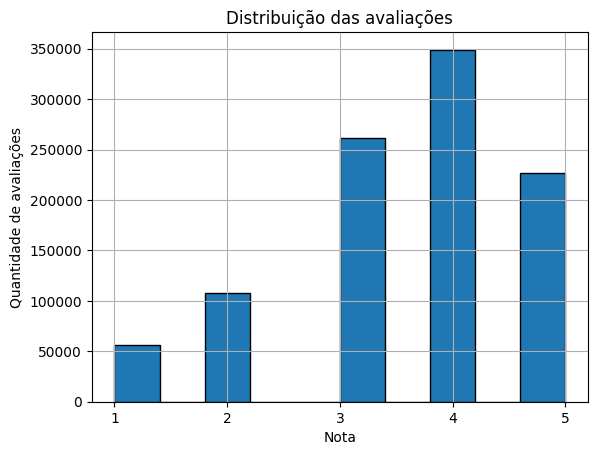

In [28]:
df_ratings['rating'].hist(edgecolor='black')
plt.title('Distribuição das avaliações')
plt.xlabel('Nota')
plt.ylabel('Quantidade de avaliações')
plt.xticks([1, 2, 3, 4, 5])
plt.show()


In [29]:
def extract_year(title):
    match = re.search(r'\((\d{4})\)', title)
    if match:
        return match.group(1)
    return None
df_movies_ead = df_movies.copy()
df_movies_ead['year'] = df_movies_ead['title'].apply(extract_year)

genres_split = df_movies_ead['genres'].str.get_dummies(sep='|')

df_movies_ead = pd.concat([df_movies_ead, genres_split], axis=1)

df_movies_ead.drop('genres', axis=1, inplace=True)
df_movies_ead.head()

,movie_id,title,year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),1995,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),1995,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


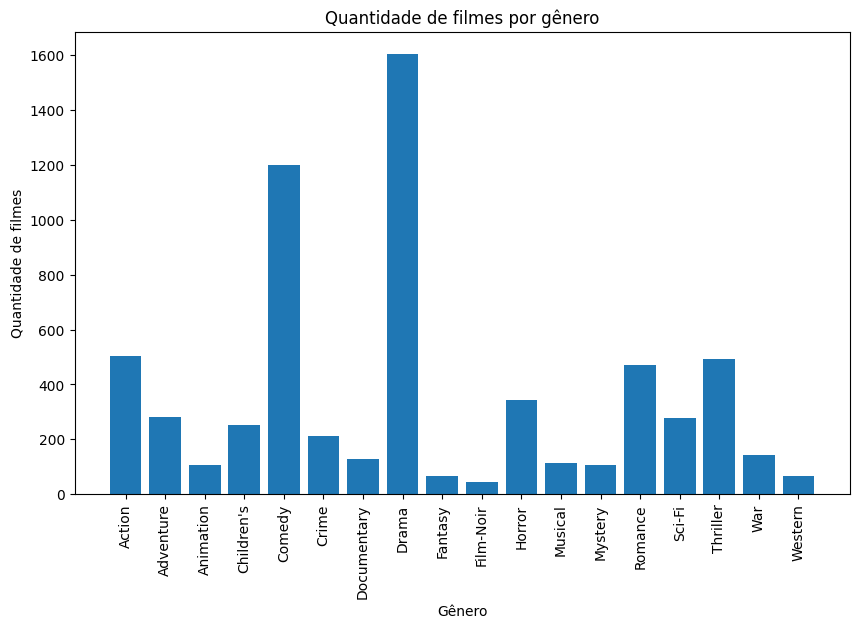

In [30]:
genres = genres_split.columns
genres_count = genres_split.sum().values

plt.figure(figsize=(10, 6))
plt.bar(genres, genres_count)
plt.xticks(rotation=90)
plt.title('Quantidade de filmes por gênero')
plt.ylabel('Quantidade de filmes')
plt.xlabel('Gênero')
plt.show()


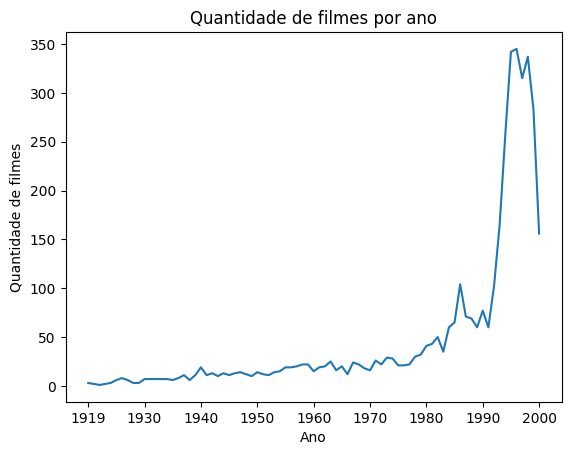

In [31]:
df_movies_ead.groupby('year').size().plot()
plt.title('Quantidade de filmes por ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade de filmes')
plt.show()

In [32]:
most_watched = df_ratings.groupby('movie_id').size().sort_values(ascending=False)

most_watched = pd.DataFrame({'movie_id': most_watched.index, 'count': most_watched.values})

most_watched['mean'] = df_ratings.groupby('movie_id')['rating'].mean().values

most_watched = pd.merge(most_watched, df_movies, on='movie_id')

print("Top 10 filmes mais assistidos:")
most_watched[['mean', 'count', 'title']].head(10)


Top 10 filmes mais assistidos:


,mean,count,title
0,4.146846,3428,American Beauty (1999)
1,3.201141,2991,Star Wars: Episode IV - A New Hope (1977)
2,3.016736,2990,Star Wars: Episode V - The Empire Strikes Back...
3,2.729412,2883,Star Wars: Episode VI - Return of the Jedi (1983)
4,3.006757,2672,Jurassic Park (1993)
5,3.878723,2653,Saving Private Ryan (1998)
6,3.410480,2649,Terminator 2: Judgment Day (1991)
7,3.014706,2590,"Matrix, The (1999)"
8,2.656863,2583,Back to the Future (1985)
9,3.540541,2578,"Silence of the Lambs, The (1991)"


In [33]:
best_rated = df_ratings.groupby('movie_id')['rating'].agg(['mean', 'count'])
best_rated = best_rated[best_rated['count'] > 100]
best_rated = pd.merge(best_rated, df_movies, on='movie_id')
best_rated = best_rated.sort_values(by='mean', ascending=False)

print('Top 10 filmes com a melhor nota média e mais de 100 avaliações:')
best_rated[['mean', 'count', 'title']].head(10)

Top 10 filmes com a melhor nota média e mais de 100 avaliações:


,mean,count,title
1012,4.560510,628,Seven Samurai (The Magnificent Seven) (Shichin...
171,4.554558,2227,"Shawshank Redemption, The (1994)"
411,4.524966,2223,"Godfather, The (1972)"
373,4.520548,657,"Close Shave, A (1995)"
38,4.517106,1783,"Usual Suspects, The (1995)"
291,4.510417,2304,Schindler's List (1993)
562,4.507937,882,"Wrong Trousers, The (1993)"
442,4.491489,470,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
585,4.477725,2514,Raiders of the Lost Ark (1981)
425,4.476190,1050,Rear Window (1954)


In [34]:

print('ratings.dat:')
print('Quantidade de valores duplicados: {}'.format(df_ratings.duplicated().sum()))
print('Quantidade de valores faltantes: {}'.format(df_ratings.isnull().sum().sum()))


ratings.dat:
Quantidade de valores duplicados: 0
Quantidade de valores faltantes: 0


In [35]:
print('movies.dat:')
print('Quantidade de valores duplicados: {}'.format(df_movies.duplicated().sum()))
print('Quantidade de valores faltantes: {}'.format(df_movies.isnull().sum().sum()))

movies.dat:
Quantidade de valores duplicados: 0
Quantidade de valores faltantes: 0


Regarding the dataset, we can see that there are no duplicate values ​​or missing values, but it is still a sparse matrix, since many users did not rate many films.

## application of clustering algorithms

In [36]:
user_item_matrix = df_ratings.pivot(index='user_id', columns='movie_id', values='rating')

user_avg_rating = user_item_matrix.mean(axis=1)

user_item_matrix = user_item_matrix.fillna(0)

user_item_matrix_subtracted = user_item_matrix.subtract(user_avg_rating, axis=0)

movie_user_matrix = user_item_matrix_subtracted.T
X = movie_user_matrix.values

In [37]:
scaler = StandardScaler()
scaled_movie_user_matrix = scaler.fit_transform(X)

In [38]:
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_movie_user_matrix)

Let's look at the results obtained with the KMeans algorithm without using PCA.

In [39]:
for cluster in range(n_clusters):
    cluster_movies = movie_user_matrix.iloc[cluster_labels == cluster].index
    movies = df_movies[df_movies['movie_id'].isin(cluster_movies)][['title', 'genres']]
    print('Cluster {}, tamanho {}'.format(cluster, np.sum(cluster_labels == cluster)))
    print('Filmes do cluster {}:'.format(cluster))
    print(movies.head(10))


Cluster 0, tamanho 3122
Filmes do cluster 0:
                                 title                    genres
2              Grumpier Old Men (1995)            Comedy|Romance
3             Waiting to Exhale (1995)              Comedy|Drama
4   Father of the Bride Part II (1995)                    Comedy
6                       Sabrina (1995)            Comedy|Romance
7                  Tom and Huck (1995)      Adventure|Children's
8                  Sudden Death (1995)                    Action
11  Dracula: Dead and Loving It (1995)             Comedy|Horror
12                        Balto (1995)      Animation|Children's
13                        Nixon (1995)                     Drama
14             Cutthroat Island (1995)  Action|Adventure|Romance
Cluster 1, tamanho 2
Filmes do cluster 1:
                         title                   genres
523    Schindler's List (1993)                Drama|War
586  Dances with Wolves (1990)  Adventure|Drama|Western
Cluster 2, tamanho 1
Filmes do

Interesting to observe:

- Cluster 7: contains two films from the Star Wars franchise
- Cluster 9: contains several science fiction films
- Cluster 17: contains two films from the Godfather franchise
- Cluster 10: contains several children's films.

Although these seem good, we also have cluster 14, which combines several crime films (such as Se7en and From Dusk Till Dawn) with the children's film Jumanji.

We will try to use PCA to reduce the dimensionality of the data and try to obtain more significant clusters. We used an arbitrary value of 20 clusters, but we can try other values. In addition, we will also look for a better value for the number of PCA components.

# PCA

In [40]:
n_components = 2

pca = PCA(n_components=n_components)
pca_transformed_data_2 = pca.fit_transform(scaled_movie_user_matrix)

C:\Users\Lucas S. Tavares\AppData\Local\Temp\ipykernel_15900\2902792327.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20', n_clusters)


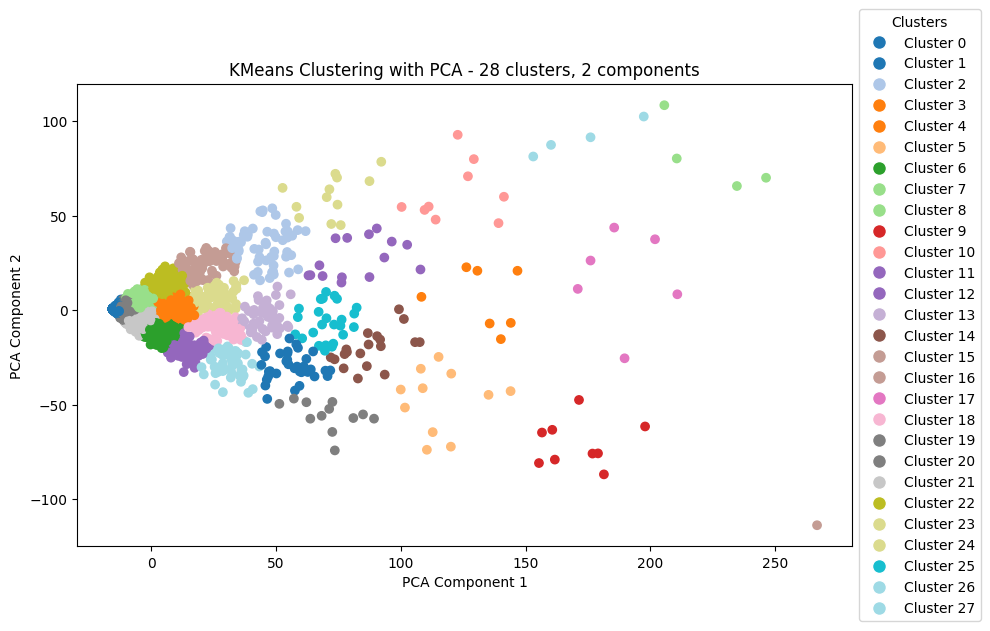

In [41]:
n_clusters = 28

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(pca_transformed_data_2)
cluster_labels_pca_2 = kmeans.predict(pca_transformed_data_2)

colormap = plt.cm.get_cmap('tab20', n_clusters)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_transformed_data_2[:, 0], pca_transformed_data_2[:, 1], c=cluster_labels_pca_2, cmap=colormap)

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colormap(i), markersize=10, label='Cluster {}'.format(i)) for i in range(n_clusters)]
plt.legend(handles=legend_handles, title='Clusters', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('KMeans Clustering with PCA - {} clusters, {} components'.format(n_clusters, n_components))
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [42]:
for cluster in range(n_clusters):
    cluster_movies = movie_user_matrix.iloc[cluster_labels_pca_2 == cluster].index
    movies = df_movies[df_movies['movie_id'].isin(cluster_movies)][['title', 'genres']]
    print('Cluster {}, tamanho {}'.format(cluster, np.sum(cluster_labels_pca_2 == cluster)))
    print('Filmes do cluster {}:'.format(cluster))
    print(movies.head(10))


Cluster 0, tamanho 1526
Filmes do cluster 0:
                              title                genres
7               Tom and Huck (1995)  Adventure|Children's
26              Now and Then (1995)                 Drama
32          Wings of Courage (1995)     Adventure|Romance
34                Carrington (1995)         Drama|Romance
36    Across the Sea of Time (1995)           Documentary
37              It Takes Two (1995)                Comedy
39  Cry, the Beloved Country (1995)                 Drama
48     When Night Is Falling (1995)         Drama|Romance
52                  Lamerica (1994)                 Drama
53            Big Green, The (1995)     Children's|Comedy
Cluster 1, tamanho 35
Filmes do cluster 1:
                                    title                        genres
35                Dead Man Walking (1995)                         Drama
38                        Clueless (1995)                Comedy|Romance
353    Four Weddings and a Funeral (1994)                C

In [43]:
n_components = 3

pca = PCA(n_components=n_components)
pca_transformed_data_3 = pca.fit_transform(scaled_movie_user_matrix)

C:\Users\Lucas S. Tavares\AppData\Local\Temp\ipykernel_15900\2332146382.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20', n_clusters)


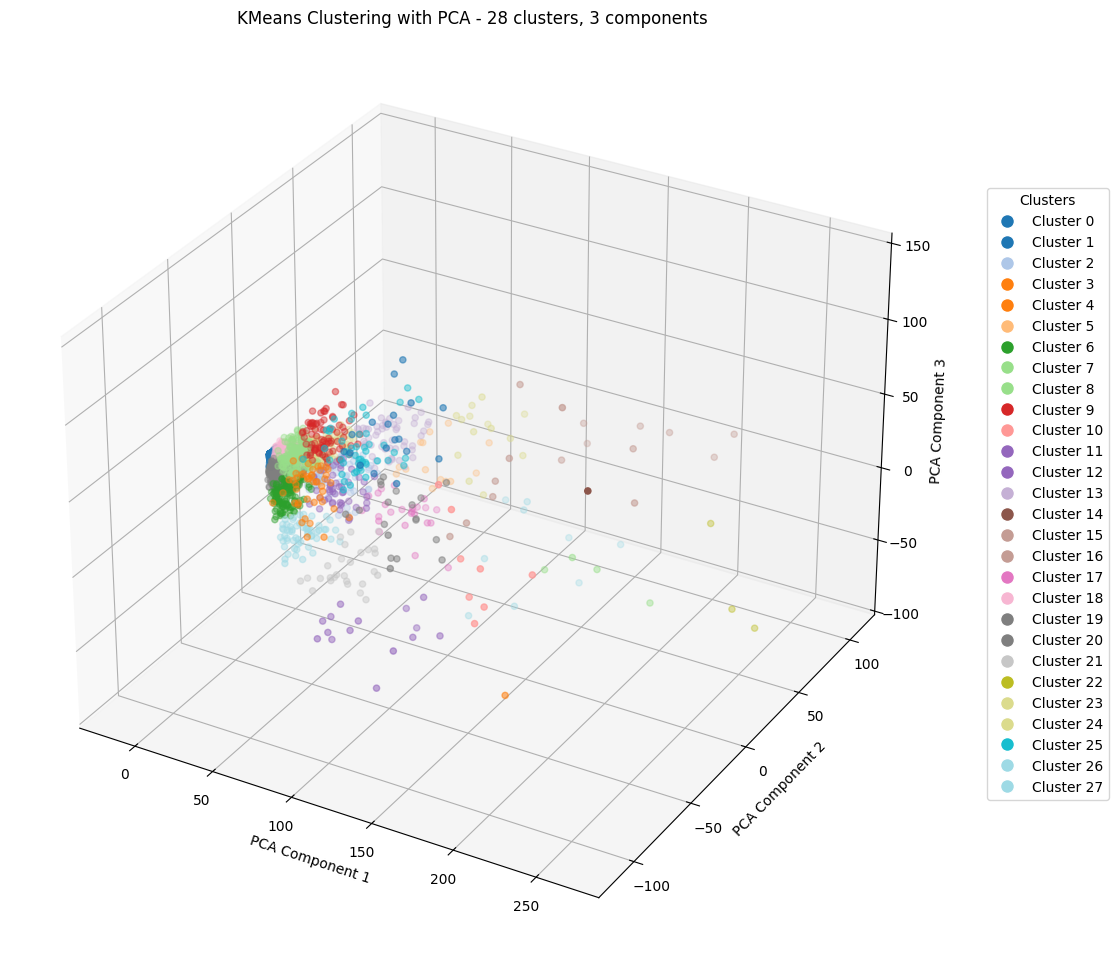

In [44]:
n_clusters = 28
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

kmeans.fit(pca_transformed_data_3)
cluster_labels_pca_3 = kmeans.predict(pca_transformed_data_3)

colormap = plt.cm.get_cmap('tab20', n_clusters)

fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(pca_transformed_data_3[:, 0], pca_transformed_data_3[:, 1], pca_transformed_data_3[:, 2], c=cluster_labels_pca_3, cmap=colormap)

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colormap(i), markersize=10, label='Cluster {}'.format(i)) for i in range(n_clusters)]
ax.legend(handles=legend_handles, title='Clusters', loc='center left', bbox_to_anchor=(1.05, 0.5))

plt.title('KMeans Clustering with PCA - {} clusters, {} components'.format(n_clusters, n_components))
plt.show()

In [45]:
for cluster in range(n_clusters):
    cluster_movies = movie_user_matrix.iloc[cluster_labels_pca_3 == cluster].index
    movies = df_movies[df_movies['movie_id'].isin(cluster_movies)][['title', 'genres']]
    print('Cluster {}, tamanho {}'.format(cluster, np.sum(cluster_labels_pca_3 == cluster)))
    print('Filmes do cluster {}:'.format(cluster))
    print(movies.head(10))


Cluster 0, tamanho 1889
Filmes do cluster 0:
                                                title                genres
7                                 Tom and Huck (1995)  Adventure|Children's
11                 Dracula: Dead and Loving It (1995)         Comedy|Horror
12                                       Balto (1995)  Animation|Children's
25                                     Othello (1995)                 Drama
26                                Now and Then (1995)                 Drama
29  Shanghai Triad (Yao a yao yao dao waipo qiao) ...                 Drama
32                            Wings of Courage (1995)     Adventure|Romance
34                                  Carrington (1995)         Drama|Romance
36                      Across the Sea of Time (1995)           Documentary
37                                It Takes Two (1995)                Comedy
Cluster 1, tamanho 18
Filmes do cluster 1:
                                             title  \
220                   

We can observe some interisting:

- Cluster 22: Original Star Wars trilogy
- Cluster 5: Contains several science fiction films, including 5 from the Star Trek franchise
- Cluster 2: Contains several animated films
- Cluster 15: Contains several films by Bill Murray and Tom Hanks

Still not very satisfactory, let's try using SVD instead of PCA to try to obtain more significant clusters.

## SVD

In [46]:
n_components = 2
svd = TruncatedSVD(n_components=n_components)
svd_transformed_data_2 = svd.fit_transform(scaled_movie_user_matrix)

In [47]:
singular_values_squared = svd.explained_variance_

singular_values = np.sqrt(singular_values_squared)

sigma_matrix = np.diag(singular_values)

print("Matriz diagonal da decomposição SVD:")
print(sigma_matrix)

Matriz diagonal da decomposição SVD:
[[27.1079158   0.        ]
 [ 0.         12.68668665]]


C:\Users\Lucas S. Tavares\AppData\Local\Temp\ipykernel_15900\2633135023.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20', n_clusters)


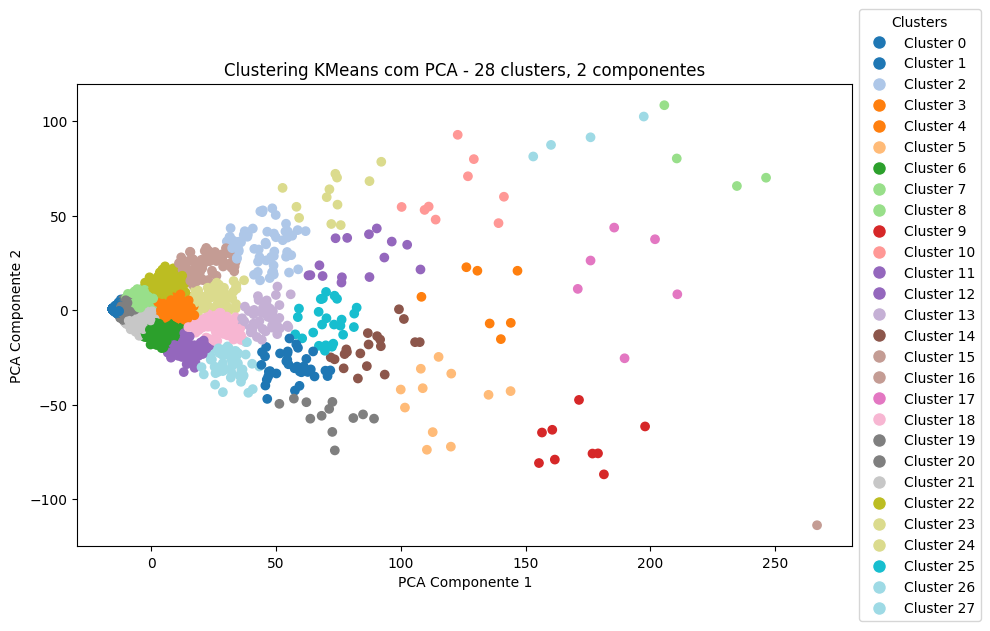

In [48]:
n_clusters = 28

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(svd_transformed_data_2)
cluster_labels_svd_2 = kmeans.predict(svd_transformed_data_2)

colormap = plt.cm.get_cmap('tab20', n_clusters)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(svd_transformed_data_2[:, 0], svd_transformed_data_2[:, 1], c=cluster_labels_svd_2, cmap=colormap)

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colormap(i), markersize=10, label='Cluster {}'.format(i)) for i in range(n_clusters)]
plt.legend(handles=legend_handles, title='Clusters', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Clustering KMeans com PCA - {} clusters, {} componentes'.format(n_clusters, n_components))
plt.xlabel('PCA Componente 1')
plt.ylabel('PCA Componente 2')
plt.show()


In [49]:
for cluster in range(n_clusters):
    cluster_movies = movie_user_matrix.iloc[cluster_labels_pca_3 == cluster].index
    movies = df_movies[df_movies['movie_id'].isin(cluster_movies)][['title', 'genres']]
    print('Cluster {}, tamanho {}'.format(cluster, np.sum(cluster_labels_pca_3 == cluster)))
    print('Filmes do cluster {}:'.format(cluster))
    print(movies.head(10))


Cluster 0, tamanho 1889
Filmes do cluster 0:
                                                title                genres
7                                 Tom and Huck (1995)  Adventure|Children's
11                 Dracula: Dead and Loving It (1995)         Comedy|Horror
12                                       Balto (1995)  Animation|Children's
25                                     Othello (1995)                 Drama
26                                Now and Then (1995)                 Drama
29  Shanghai Triad (Yao a yao yao dao waipo qiao) ...                 Drama
32                            Wings of Courage (1995)     Adventure|Romance
34                                  Carrington (1995)         Drama|Romance
36                      Across the Sea of Time (1995)           Documentary
37                                It Takes Two (1995)                Comedy
Cluster 1, tamanho 18
Filmes do cluster 1:
                                             title  \
220                   

## DBSCAN

In [50]:
dbscan = DBSCAN(eps=1, min_samples=5)
dbscan.fit(pca_transformed_data_2)

labels = dbscan.labels_

unique_labels, counts = np.unique(labels, return_counts=True)
print("Clusters:", dict(zip(unique_labels, counts)))

Clusters: {np.int64(-1): np.int64(843), np.int64(0): np.int64(2666), np.int64(1): np.int64(34), np.int64(2): np.int64(15), np.int64(3): np.int64(12), np.int64(4): np.int64(15), np.int64(5): np.int64(5), np.int64(6): np.int64(6), np.int64(7): np.int64(32), np.int64(8): np.int64(13), np.int64(9): np.int64(7), np.int64(10): np.int64(5), np.int64(11): np.int64(10), np.int64(12): np.int64(6), np.int64(13): np.int64(8), np.int64(14): np.int64(5), np.int64(15): np.int64(4), np.int64(16): np.int64(9), np.int64(17): np.int64(6), np.int64(18): np.int64(5)}


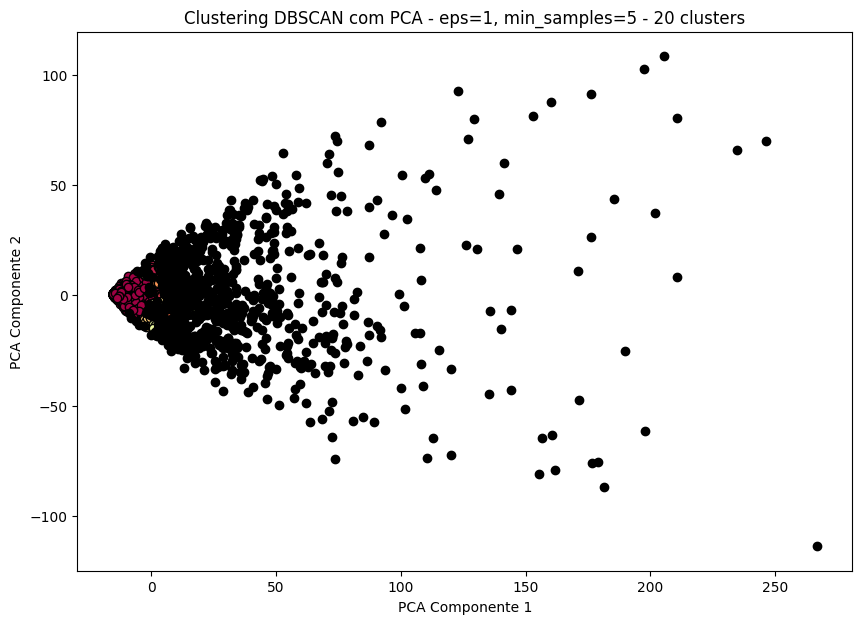

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = pca_transformed_data_2[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('Clustering DBSCAN com PCA - eps=1, min_samples=5 - {} clusters'.format(len(unique_labels)))
plt.xlabel('PCA Componente 1')
plt.ylabel('PCA Componente 2')
plt.show()


In [52]:
for cluster in unique_labels:
    if cluster == -1:
        continue

    cluster_movies = movie_user_matrix.iloc[labels == cluster].index
    movies = df_movies[df_movies['movie_id'].isin(cluster_movies)][['title', 'genres']]
    print(f'Cluster {cluster}, tamanho {np.sum(labels == cluster)}')
    print(f'Filmes do cluster {cluster}:')
    print(movies.head(10))

Cluster 0, tamanho 2666
Filmes do cluster 0:
                                    title                    genres
3                Waiting to Exhale (1995)              Comedy|Drama
4      Father of the Bride Part II (1995)                    Comedy
7                     Tom and Huck (1995)      Adventure|Children's
8                     Sudden Death (1995)                    Action
11     Dracula: Dead and Loving It (1995)             Comedy|Horror
12                           Balto (1995)      Animation|Children's
13                           Nixon (1995)                     Drama
14                Cutthroat Island (1995)  Action|Adventure|Romance
17                      Four Rooms (1995)                  Thriller
18  Ace Ventura: When Nature Calls (1995)                    Comedy
Cluster 1, tamanho 34
Filmes do cluster 1:
                                   title                          genres
59    Indian in the Cupboard, The (1995)    Adventure|Children's|Fantasy
166               

Interesting to observe:

- Cluster 9: Has several science fiction films
- Cluster 11: Has several mystery films

However, we still did not obtain very significant clusters. Let's try to use DBSCAN + PCA with three components.

In [54]:
dbscan = DBSCAN(eps=4, min_samples=7)
dbscan.fit(pca_transformed_data_3)

labels = dbscan.labels_

unique_labels, counts = np.unique(labels, return_counts=True)
print("Clusters:", dict(zip(unique_labels, counts)))

Clusters: {np.int64(-1): np.int64(642), np.int64(0): np.int64(3018), np.int64(1): np.int64(9), np.int64(2): np.int64(9), np.int64(3): np.int64(12), np.int64(4): np.int64(7), np.int64(5): np.int64(9)}


C:\Users\Lucas S. Tavares\AppData\Local\Temp\ipykernel_15900\327431524.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20', n_clusters)
C:\Users\Lucas S. Tavares\AppData\Local\Temp\ipykernel_15900\327431524.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=color, marker=marker, label=f'Cluster {label}' if label != -1 else 'Noise')


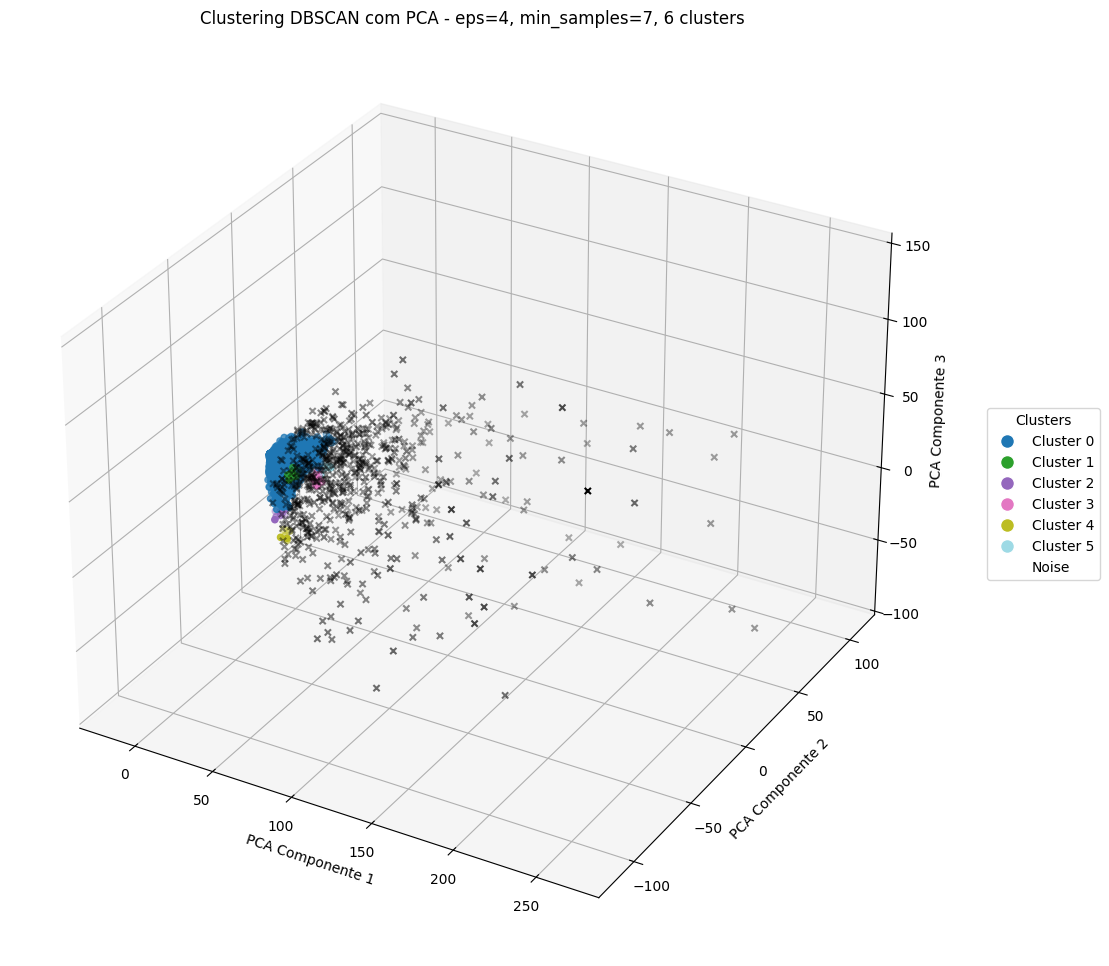

In [55]:
unique_labels = set(labels)
n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
colormap = plt.cm.get_cmap('tab20', n_clusters)

fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection='3d')

for label in unique_labels:
    if label == -1:
        color = 'k'
        marker = 'x'
    else:
        color = colormap(label)
        marker = 'o'

    class_member_mask = (labels == label)
    xyz = pca_transformed_data_3[class_member_mask]
    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=color, marker=marker, label=f'Cluster {label}' if label != -1 else 'Noise')

ax.set_xlabel('PCA Componente 1')
ax.set_ylabel('PCA Componente 2')
ax.set_zlabel('PCA Componente 3')

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colormap(i), markersize=10, label=f'Cluster {i}') for i in range(n_clusters)]
if -1 in labels:
    legend_handles.append(plt.Line2D([0], [0], marker='x', color='w', markerfacecolor='k', markersize=10, label='Noise'))
ax.legend(handles=legend_handles, title='Clusters', loc='center left', bbox_to_anchor=(1.05, 0.5))

plt.title(f'Clustering DBSCAN com PCA - eps=4, min_samples=7, {n_clusters} clusters')
plt.show()

In [56]:
for cluster in unique_labels:
    if cluster == -1:
        continue

    cluster_movies = movie_user_matrix.iloc[labels == cluster].index
    movies = df_movies[df_movies['movie_id'].isin(cluster_movies)][['title', 'genres']]
    print(f'Cluster {cluster}, tamanho {np.sum(labels == cluster)}')
    print(f'Filmes do cluster {cluster}:')
    print(movies.head(10))

Cluster 0, tamanho 3018
Filmes do cluster 0:
                                 title                    genres
2              Grumpier Old Men (1995)            Comedy|Romance
3             Waiting to Exhale (1995)              Comedy|Drama
4   Father of the Bride Part II (1995)                    Comedy
6                       Sabrina (1995)            Comedy|Romance
7                  Tom and Huck (1995)      Adventure|Children's
8                  Sudden Death (1995)                    Action
11  Dracula: Dead and Loving It (1995)             Comedy|Horror
12                        Balto (1995)      Animation|Children's
13                        Nixon (1995)                     Drama
14             Cutthroat Island (1995)  Action|Adventure|Romance
Cluster 1, tamanho 9
Filmes do cluster 1:
                                                  title                genres
338                             Muriel's Wedding (1994)        Comedy|Romance
341   Adventures of Priscilla, Queen of th

Interesting to observe:

- Cluster 5: Has several science fiction films
- Cluster 3: Has several Disney animated films (although it insists on grouping Carrie and Halloween together...)
- Cluster 4: Has several noir films

After trying different values ​​for the DBSCAN parameters, we obtained significant clusters, although not very satisfactory in relation to K-Means.

## Hierarchical clustering

In [57]:
n_clusters = 28

hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
cluster_labels_hierarchical = hierarchical.fit_predict(pca_transformed_data_2)

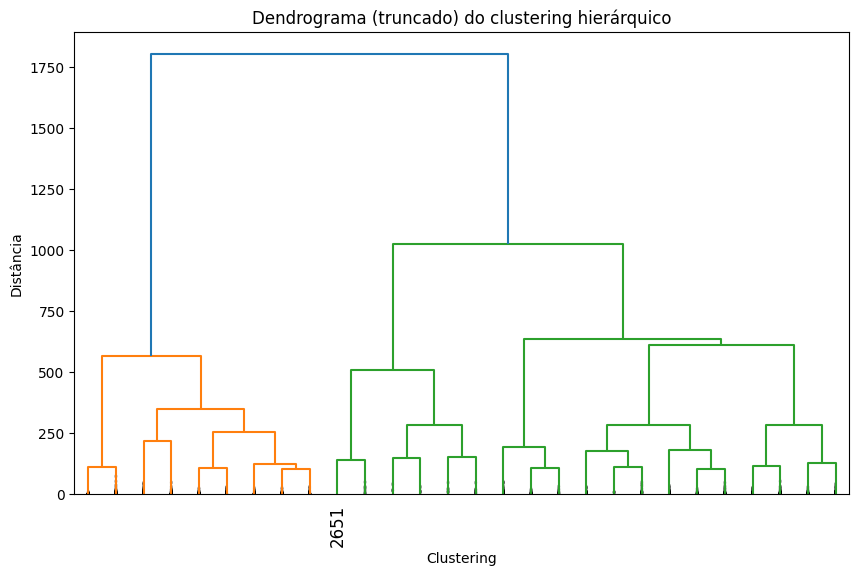

In [58]:

linked = linkage(pca_transformed_data_2, 'ward')

plt.figure(figsize=(10, 6))
dendrogram(linked,
           truncate_mode='lastp',
           p=n_clusters,
           show_leaf_counts=False,
           leaf_rotation=90.,
           leaf_font_size=12.,
           show_contracted=True)

plt.title('Dendrograma (truncado) do clustering hierárquico')
plt.xlabel('Clustering')
plt.ylabel('Distância')
plt.show()

C:\Users\Lucas S. Tavares\AppData\Local\Temp\ipykernel_15900\3445498951.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20', n_clusters)


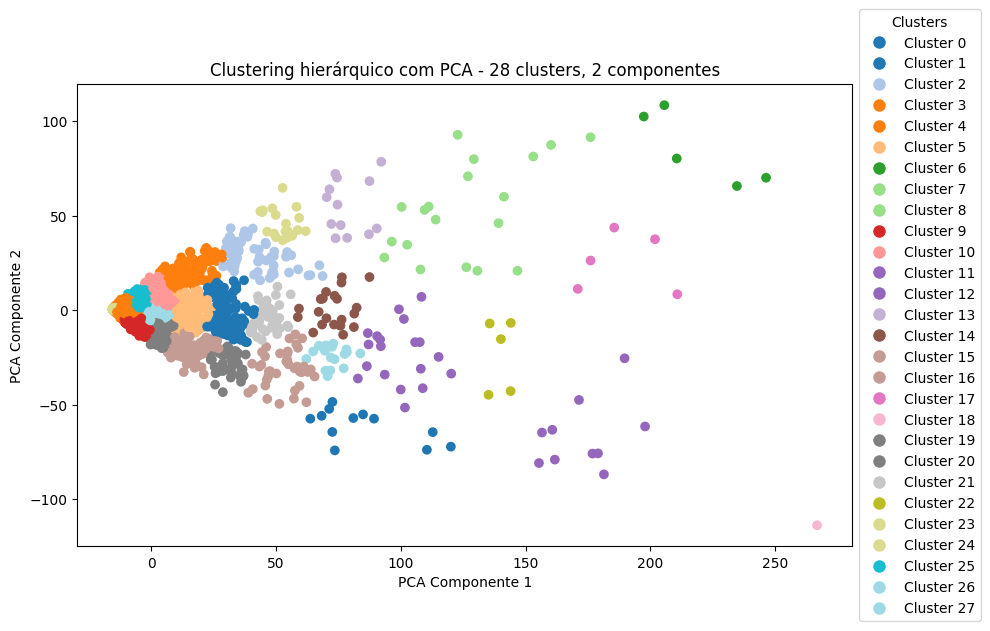

In [59]:
colormap = plt.cm.get_cmap('tab20', n_clusters)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_transformed_data_2[:, 0], pca_transformed_data_2[:, 1], c=cluster_labels_hierarchical, cmap=colormap)

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colormap(i), markersize=10, label='Cluster {}'.format(i)) for i in range(n_clusters)]
plt.legend(handles=legend_handles, title='Clusters', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Clustering hierárquico com PCA - {} clusters, {} componentes'.format(n_clusters, pca_transformed_data_2.shape[1]))
plt.xlabel('PCA Componente 1')
plt.ylabel('PCA Componente 2')
plt.show()

In [60]:
for cluster in range(n_clusters):
    cluster_movies = movie_user_matrix.iloc[cluster_labels_hierarchical == cluster].index
    movies = df_movies[df_movies['movie_id'].isin(cluster_movies)][['title', 'genres']]
    print('Cluster {}, tamanho {}'.format(cluster, np.sum(cluster_labels_hierarchical == cluster)))
    print('Filmes do cluster {}:'.format(cluster))
    print(movies.head(10))


Cluster 0, tamanho 88
Filmes do cluster 0:
                                      title                        genres
15                            Casino (1995)                Drama|Thriller
102                    Happy Gilmore (1996)                        Comedy
159                     Crimson Tide (1995)            Drama|Thriller|War
250       Interview with the Vampire (1994)                  Drama|Horror
437               Dazed and Confused (1993)                        Comedy
450                        Firm, The (1993)                Drama|Thriller
496                   Mrs. Doubtfire (1993)                        Comedy
551                     True Romance (1993)          Action|Crime|Romance
590  Snow White and the Seven Dwarfs (1937)  Animation|Children's|Musical
735                   Close Shave, A (1995)     Animation|Comedy|Thriller
Cluster 1, tamanho 12
Filmes do cluster 1:
                                       title                      genres
109                       T

Interesting to observe:

- Cluster 6: Contains several science fiction films, such as the original Star Wars trilogy
- Cluster 7: Contains several science fiction films, with the two films in the Alien franchise
- Cluster 18: Cluster of only one film: American Beauty, the most watched in the dataset

## Conclusion

### Key Findings:

- **KMeans:**

  Initially, using 20 clusters without dimensionality reduction, the algorithm produced interesting groupings, including movies from specific franchises (e.g., *Star Wars*, *The Godfather*) and genres (e.g., science fiction, children’s films).

  After applying PCA with 2 and 3 components and adjusting the number of clusters to 28, more refined groupings emerged, though some clusters still exhibited genre overlap. When using SVD with 2 components, the clustering highlighted distinct franchises and genres more clearly.

- **DBSCAN:**

  When combined with PCA, DBSCAN did not yield clusters as distinct as those from KMeans. However, it still managed to uncover meaningful groupings, such as science fiction and mystery films. Parameter tuning (specifically `eps` and `min_samples`) demonstrated that DBSCAN could detect relevant patterns, but overall, its results were less interpretable than those from KMeans.

- **Hierarchical Clustering:**

  Using Agglomerative Clustering, we identified clusters that emphasized specific franchises and genres. The dendrogram provided a visual representation of cluster hierarchies, revealing relationships and proximities among the groupings.

### Final Summary:

Among all techniques evaluated, **KMeans combined with PCA** delivered the most coherent and interpretable film clusters, especially when experimenting with various numbers of components and clusters. While some clusters still mixed unrelated genres, many effectively captured clear thematic or franchise-based groupings. Both PCA and SVD were instrumental in reducing data dimensionality, enhancing visualization and interpretation. DBSCAN showed potential for density-based clustering but lacked the clarity of KMeans results. Hierarchical clustering offered valuable insight into film relationships, though its interpretability was occasionally limited.
